In [13]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
# %cd /content/drive/MyDrive/liar_dataset/processed_dataset
%cd /content/drive/MyDrive/liar2_dataset/processed_dataset

/content/drive/MyDrive/liar2_dataset/processed_dataset


Training set label distribution:
label
1    5284
3    2967
2    2882
4    2743
0    2425
5    2068
Name: count, dtype: int64
valid set label distribution:
label
1    661
3    371
2    361
4    343
0    303
5    258
Name: count, dtype: int64
test set label distribution:
label
1    660
3    371
2    360
4    343
0    303
5    259
Name: count, dtype: int64
 Classification Report:
              precision    recall  f1-score   support

  pants-fire       0.39      0.17      0.24       303
       false       0.36      0.62      0.46       660
 barely-true       0.22      0.16      0.19       360
   half-true       0.25      0.21      0.23       371
 mostly-true       0.19      0.18      0.19       343
        true       0.31      0.16      0.21       259

    accuracy                           0.31      2296
   macro avg       0.29      0.25      0.25      2296
weighted avg       0.29      0.31      0.28      2296



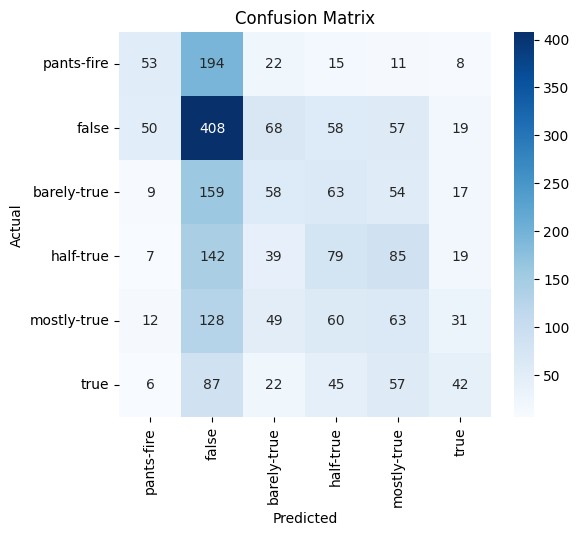


 Top 5 Misclassified Samples:

[1] Statement: say joe biden is pedophile
True: pants-fire | Pred: false
[3] Statement: cost enrollee obamacare next years
True: false | Pred: barely-true
[4] Statement: federal register houses washington regulations is pages length weighs more pounds
True: half-true | Pred: barely-true
[5] Statement: following session texas house speaker joe straus was acknowledged 'thanked 'tireless efforts planned parenthood nation premier abortion provider
True: true | Pred: mostly-true
[6] Statement: america was only country ended slavery
True: false | Pred: mostly-true


,id,label,statement,date,subject,speaker,speaker_description,state_info,true_counts,mostly_true_counts,...,pants_on_fire_counts,context,justification,clean_statement,clean_statement_svm,clean_statement_bert,label_text,true_label,predicted_label,correct
0,21750,1,Three doctors from the same hospital 'die sudd...,"July 28, 2022",facebook fact-checks;coronavirus,the gateway pundit,The Gateway Pundit is a conservative website.,NaN,1,1,...,3,a post,""" Segall’s obituary said he died ""after a un...",three doctors hospital suddenly week hospital ...,doctors same hospital suddenly same week hospi...,Three doctors from the same hospital 'die sudd...,false,1,1,True
1,18173,0,Say Joe Biden is a pedophile.,"July 17, 2020",facebook fact-checks,facebook posts,Posters on Facebook and other social media net...,NaN,24,50,...,570,Facebook posts,Social media users that Biden is a pedophile....,say joe biden pedophile,say joe biden is pedophile,Say Joe Biden is a pedophile.,pants-fire,0,1,False
2,22673,1,A photo shows President Joe Biden and Ukrainia...,"February 20, 2023",facebook fact-checks;ukraine,viral image,"Graphics, pictures and charts shared on social...",NaN,4,13,...,331,an Instagram post,The image appears to show Biden and Zelenskyy ...,photo shows president joe biden ukrainian pres...,photo shows president joe biden ukrainian pres...,A photo shows President Joe Biden and Ukrainia...,false,1,1,True
3,9897,1,"It will cost $50,000 per enrollee in Obamacare...","January 27, 2015",health care;taxes;punditfact,stuart varney,Stuart Varney is a British business journalist...,NaN,0,0,...,0,"an interview on Fox News' ""America's Newsroom""","Varney said that it will cost taxpayers $50,00...",cost per enrollee obamacare next years,cost enrollee obamacare next years,"It will cost $50,000 per enrollee in Obamacare...",false,1,2,False
4,3855,3,The Federal Register - which houses all Washin...,"June 14, 2011",regulation,randy forbes,Randy Forbes is from Chesapeake and represents...,virginia,5,3,...,0,a statement,To recap: To argue that regulation is out of c...,federal register houses washington regulations...,federal register houses washington regulations...,The Federal Register - which houses all Washin...,half-true,3,2,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2291,14702,1,"Says ""Rosie O'Donnell apparently committed the...","June 4, 2018",campaign finance,ted cruz,"Ted Cruz is a U.S. Senator from Texas, first e...",national,8,22,...,11,an interview,"Cruz said, ""Rosie O’Donnell apparently committ...",says rosie apparently committed offense five t...,says rosie o'donnell apparently committed same...,"Says ""Rosie O'Donnell apparently committed the...",false,1,4,False
2292,21084,1,"An image shows ""Ukrainian soldiers praying.","March 6, 2022",facebook fact-checks;ukraine,facebook posts,Posters on Facebook and other social media net...,NaN,24,50,...,570,a post,"In October 2017, SML Ministries shared the pho...",image shows ukrainian soldiers praying,image shows ukrainian soldiers praying,"An image shows ""Ukrainian soldiers praying.",false,1,1,True
2293,15667,4,Since 1938 the minimum wage has been increased...,"February 11, 2019",congress;income;labor;voting record;facebook f...,facebook posts,Posters on Facebook and other social media net...,NaN,24,50,...,570,a Facebook post,"A social media meme claims that since 1938, th...",since minimum wage increased times raised time...,minimum wage has been increased times was rais...,Since 1938 the minimum wage has been increased...,mostly-true,4,3,False
2294,3313,2,Says Wisconsin Supreme Court Justice David Pro...,"March 16, 2011",legal issues,joanne kloppenburg,JoAnne Kloppenburg of Madison is state Court o...,wisconsin,0,2,...,1,a newspaper interview,"The fact that Prosser disavowed one statement,...",says wisconsin supreme court justice david pro...,says wisconsin supreme court justice david pro...,Says Wisconsin Supreme Court Justice David Pro...,bar

In [19]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


train_df = pd.read_csv('processed_train.csv')
val_df = pd.read_csv('processed_valid.csv')
test_df = pd.read_csv('processed_test.csv')


print("Training set label distribution:")
print(train_df["label"].value_counts())

print("valid set label distribution:")
print(val_df["label"].value_counts())

print("test set label distribution:")
print(test_df["label"].value_counts())


def extract_features(train_df, val_df, test_df, max_features=5000):
    vectorizer = TfidfVectorizer(stop_words='english', max_features=max_features)

    X_train = vectorizer.fit_transform(train_df["clean_statement_svm"])
    X_val = vectorizer.transform(val_df["clean_statement_svm"])
    X_test = vectorizer.transform(test_df["clean_statement_svm"])

    y_train = train_df["label"]
    y_val = val_df["label"]
    y_test = test_df["label"]

    return X_train, X_val, X_test, y_train, y_val, y_test, vectorizer

def train_svm_model(X_train, y_train, C=1.0, kernel='linear'):
    svm_model = SVC(C=C, kernel=kernel, decision_function_shape='ovr')
    svm_model.fit(X_train, y_train)
    return svm_model


def predict_and_evaluate(model, X_test, y_test, label_map={0: "pants-fire", 1: "false", 2: "barely-true", 3: "half-true", 4: "mostly-true", 5: "true"}):

    y_pred = model.predict(X_test)


    print(" Classification Report:")
    print(classification_report(y_test, y_pred, target_names=label_map.values()))


    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_map.values(), yticklabels=label_map.values())
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

    return y_pred

def analyze_predictions(preds, test_df, label_col="label", label_map = {0: "pants-fire", 1: "false", 2: "barely-true",3: "half-true", 4: "mostly-true", 5: "true"}, top_k=5):
    test_df["true_label"] = test_df[label_col]
    test_df["predicted_label"] = preds
    test_df["correct"] = test_df["true_label"] == test_df["predicted_label"]

    print(f"\n Top {top_k} Misclassified Samples:\n")
    mistakes = test_df[~test_df["correct"]].head(top_k)

    for i, row in mistakes.iterrows():
        true_label_text = label_map.get(row['true_label'], f"unknown({row['true_label']})")
        predicted_label_text = label_map.get(row['predicted_label'], f"unknown({row['predicted_label']})")

        print(f"[{i}] Statement: {row['clean_statement_svm']}")
        print(f"True: {true_label_text} | Pred: {predicted_label_text}")

    return test_df




X_train, X_val, X_test, y_train, y_val, y_test, vectorizer = extract_features(train_df, val_df, test_df)
svm_model = train_svm_model(X_train, y_train)
preds = predict_and_evaluate(svm_model, X_test, y_test)
analyze_predictions(preds, test_df)